# Sep 8, 2025: fit sbm

conda env: gt

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import dill as pickle 
from scipy import sparse, stats
from scipy.special import gammaln
import graph_tool.all as gt
from glob import glob
import re 
import seaborn as sns
# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS(): pass

args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

In [3]:
np.linspace(1, 37, 5)

array([ 1., 10., 19., 28., 37.])

In [4]:
args.ANALYSIS = 'trial-end'
# args.WINDOW = np.arange(5, 8+1)
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'/home/govindas/lab-data/aba'
PARC_DESC = f'ABA_ROIs_final_gm_36'
ROI_path = (
    f'{BASE_path}/{PARC_DESC}'
)
os.makedirs(ROI_path, exist_ok=True)
TS_path = f'{ROI_path}/roi-timeseries'
os.makedirs(TS_path, exist_ok=True)

ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/analysis-{args.ANALYSIS}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
# os.makedirs(GRAPH_path, exist_ok=True)
sorted(glob(f'{GRAPH_path}/*'))

# SBM_path = f'{ROI_RESULTS_path}/model-fits'
# os.system(f'mkdir -p {SBM_path}')
# DIAG_path = f'{ROI_RESULTS_path}/diagnostics_insets'
# os.system(f'mkdir -p {DIAG_path}')

['/home/govindas/lab-data/aba/ABA_ROIs_final_gm_36/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/graphs/cond-PLAY_highR_desc-graph.gt.gz',
 '/home/govindas/lab-data/aba/ABA_ROIs_final_gm_36/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/graphs/cond-PLAY_highT_desc-graph.gt.gz',
 '/home/govindas/lab-data/aba/ABA_ROIs_final_gm_36/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/graphs/cond-PLAY_lowR_desc-graph.gt.gz',
 '/home/govindas/lab-data/aba/ABA_ROIs_final_gm_36/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/graphs/cond-PLAY_lowT_desc-graph.gt.gz']

In [5]:
args.idx_graph = 1

In [6]:
graph_file = f'/home/govindas/lab-data/aba/ABA_ROIs_final_gm_36/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/graphs/cond-PLAY_highR_desc-graph.gt.gz'

In [7]:
match = re.search(r"cond-([^_]+)_([^_]+)_desc-", graph_file)
if match:
    cond, name = match.groups()
    cond = '_'.join([cond, name]) 

In [8]:
cond

'PLAY_highR'

In [7]:
file = f'lab-data/aba/ABA_ROIs_final_gm_36/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/model-fits/sbm-nd-h/B-37/cond-PLAY_highT/'
m = re.search(r'B-(\d+)', file)
if m: 
    B, = m.groups()
B

'37'

In [9]:
g = gt.load_graph(graph_file)
g

<Graph object, undirected, with 36 vertices and 126 edges, 1 internal edge property, at 0x7f0b6578adf0>

In [10]:
def create_state(args, ):
    state_df = pd.DataFrame(columns=['a', 'd', 'o', 'h', 'm'],)
    state_df.loc['state'] = [
        gt.PPBlockState, gt.BlockState, 
        gt.OverlapBlockState, gt.NestedBlockState,
        gt.ModularityState,
    ]
    state_df.loc['state_args'] = [
        dict(), dict(deg_corr=args.dc, B=args.B), 
        dict(deg_corr=args.dc, B=args.B), dict(deg_corr=args.dc, B=args.B),
        dict(entropy_args=dict(gamma=args.gamma)),
    ]
    state, state_args = state_df[args.sbm]
    return state, state_args

In [11]:
args.sbm = 'a'
args.dc = True
args.B = 10
args.gamma = 2.0

args.sbm = 'a'
args.dc = True
args.nested = args.sbm == 'h'

args.wait = 1200
args.total_samples = 100
args.force_niter = args.total_samples
args.niter = 10


state, state_args = create_state(args)
state, state_args

(graph_tool.inference.planted_partition.PPBlockState, {})

In [12]:
def mcmc_eq(args, g, state):
    bs = [] # partitions
    Bs = np.zeros(g.num_vertices() + 1) # number of blocks
    Bes = [] # number of effective blocks
    dls = [] # description length history
    def collect_partitions(s):
        bs.append(s.b.a.copy())
        # B = s.get_nonempty_B()
        # Bs[B] += 1
        Bes.append(s.get_Be())
        dls.append(s.entropy())
        
    gt.mcmc_equilibrate(
        state, 
        wait=args.wait, 
        force_niter=args.force_niter,
        mcmc_args=dict(niter=args.niter), 
        callback=collect_partitions,
    )
    return state, bs, Bs, Bes, dls

def nested_mcmc_eq(args, g, state):
    bs = []
    Bs = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
    Bes = [[] for s in state.get_levels()]
    dls = []
    def collect_partitions(s):
        bs.append(s.get_bs())
        for l, sl in enumerate(s.get_levels()):
            # B = sl.get_nonempty_B()
            # Bs[l][B] += 1
            Be = sl.get_Be()
            Bes[l].append(Be)
        dls.append(s.entropy())
        
    gt.mcmc_equilibrate(
        state, 
        wait=args.wait, 
        force_niter=args.force_niter, 
        mcmc_args=dict(niter=args.niter),
        callback=collect_partitions,
    )
    return state, bs, Bs, Bes, dls

def posterior_modes(args, bs):
    pmode = gt.ModeClusterState(bs, nested=args.nested)
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    return pmode

def total_evidence(pmode, bs, dls):
    H = pmode.posterior_entropy()
    logB = np.mean(gammaln(np.array([len(np.unique(b)) for b in bs]) + 1))
    L = -np.mean(dls) + logB + H
    return L

def nested_total_evidence(pmode, bs, dls):
    H = pmode.posterior_entropy()
    logB = np.mean([sum(gammaln(len(np.unique(bl))+1) for bl in b) for b in bs])
    L = -np.mean(dls) + logB + H
    return L

def fit_sbm(args, g, state):
    state, bs, Bs, Bes, dls = mcmc_eq(args, g, state)
    args.nested = False
    pmode = posterior_modes(args, bs[-args.num_draws:]) # after chain equilibrates
    modes = pmode.get_modes()
    L = total_evidence(pmode, bs, dls)
    return state, bs, Bes, Bs, dls, pmode, modes, L

def fit_nested_sbm(args, g, state):
    state, bs, Bs, Bes, dls = nested_mcmc_eq(args, g, state)
    args.nested = True
    pmode = posterior_modes(args, bs[-args.num_draws:]) # after chain equilibrates
    modes = pmode.get_modes()
    L = nested_total_evidence(pmode, bs, dls)
    return state, bs, Bes, Bs, dls, pmode, modes, L

def load_graph(args, GRAPH_path):
    all_graphs = sorted(glob(f'{GRAPH_path}/*'))
    graph_file = all_graphs[args.GRAPH_IDX]
    g = gt.load_graph(graph_file)
    print(graph_file)
    return g, graph_file

def create_state(args, ):
    state_df = pd.DataFrame(columns=['a', 'd', 'o', 'h', 'm'],)
    state_df.loc['state'] = [
        gt.PPBlockState, gt.BlockState, 
        gt.OverlapBlockState, gt.NestedBlockState,
        gt.ModularityState,
    ]
    state_df.loc['state_args'] = [
        dict(), dict(deg_corr=args.dc, B=args.B), 
        dict(deg_corr=args.dc, B=args.B), dict(deg_corr=args.dc, B=args.B),
        dict(entropy_args=dict(gamma=args.gamma)),
    ]
    state, state_args = state_df[args.sbm]
    return state, state_args

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file


In [13]:
state, state_args = create_state(args)
args.num_draws = int((1/2) * args.total_samples)
if args.sbm in ['a', 'm', 'd', 'o']: # 'o' does not work for now.
    state = gt.minimize_blockmodel_dl(g, state=state, state_args=state_args)
    state, bs, Bes, Bs, dls, pmode, modes, L = fit_sbm(args, g, state)

<Axes: ylabel='Density'>

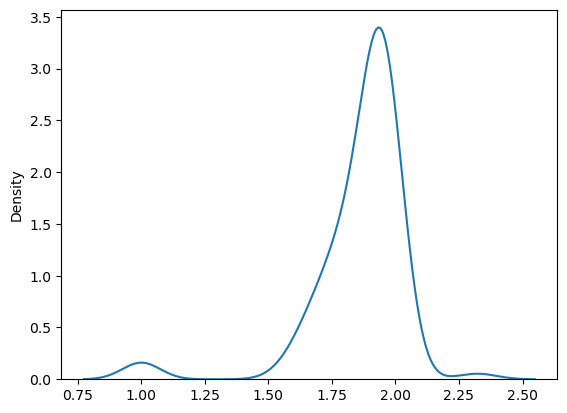

In [15]:
sns.kdeplot(Bes)